### Exploratory analysis of feature sets and segments of the dataset

In [1]:
%load_ext autoreload

In [2]:
import ReadTransform as rt
from collections import OrderedDict
from datetime import datetime
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
%matplotlib inline

In [3]:
%autoreload 2

In [4]:
from IPython.utils.text import columnize
def disp_col(list_):
    
    # import -> from IPython.utils.text import columnize
    l = list(map(lambda x:repr(x)+ ',', list_))
    print(columnize(l, displaywidth=120))

In [5]:
load_dotenv()
path = Path(os.getenv('PATH_DATASET1.2')).joinpath('user_pl_featstats')

In [6]:
# Load segment stats
path_ = path.joinpath('user_pl_segstat')
dfs = []
for f in path_.iterdir():
    dfs.append(pd.read_parquet(f))

segstat_df = pd.concat(dfs, ignore_index=True)

In [7]:
# load feature sets
path_ = path.joinpath('user_pl_feat')
dfs = []
for f in path_.iterdir():
    
    df = pd.read_parquet(f)
    pl_col = [f.name.replace('_features.parquet', '')] * len(df)
    df.insert(loc=0, column='playlist', value=pl_col)
    dfs.append(df)
    

full_feat_df = pd.concat(dfs, ignore_index=True)
feat_df = full_feat_df.loc[:, : 'artists_name']

##### We will merge segstats and feature dataframes to create one dataset
But before that we must ensure that columns we will use as keys match in both dataframes

In [8]:
# rename 'name' column to match 'track name' column in segstat_df
feat_df = feat_df.rename(columns={'name': 'track_name'})

# update track name column values to match that of in segstat_df

# add first 3 characters from artists_name
upd_trname = feat_df.track_name + '_' + feat_df.artists_name.apply(lambda x: x[:3])
# remove any special characters
upd_trname.replace(regex=r'[*|><:"?/]|\\', value='', inplace=True)
# find duplicates and add 'dup' to those track names
ind = upd_trname[upd_trname.duplicated()].index
upd_trname.iloc[ind] = upd_trname.iloc[ind].apply(lambda x: x + '_dup')

feat_df['track_name'] = upd_trname

In [9]:
new_df = pd.merge(feat_df, segstat_df, how='outer', on=['track_name', 'playlist'])
disp_col(new_df.columns)

'playlist',          'key_10',              'timbre_04_max',   'timbre_11_mean',      'timbre_06_skewness',
'danceability',      'key_11',              'timbre_05_max',   'timbre_12_mean',      'timbre_07_skewness',
'energy',            'track_name',          'timbre_06_max',   'timbre_01_min',       'timbre_08_skewness',
'loudness',          'artists_name',        'timbre_07_max',   'timbre_02_min',       'timbre_09_skewness',
'speechiness',       'timbre_01_kurtosis',  'timbre_08_max',   'timbre_03_min',       'timbre_10_skewness',
'acousticness',      'timbre_02_kurtosis',  'timbre_09_max',   'timbre_04_min',       'timbre_11_skewness',
'instrumentalness',  'timbre_03_kurtosis',  'timbre_10_max',   'timbre_05_min',       'timbre_12_skewness',
'valence',           'timbre_04_kurtosis',  'timbre_11_max',   'timbre_06_min',       'timbre_01_std',     
'tempo',             'timbre_05_kurtosis',  'timbre_12_max',   'timbre_07_min',       'timbre_02_std',     
'key_0',             'timbre

In [10]:
new_df.tail()

,playlist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,key_0,...,timbre_03_std,timbre_04_std,timbre_05_std,timbre_06_std,timbre_07_std,timbre_08_std,timbre_09_std,timbre_10_std,timbre_11_std,timbre_12_std
367,That familiar trance,0.489011,0.871102,0.348074,0.076179,0.096996,0.031860,0.410039,0.167805,0.0,...,53.760912,28.658233,24.945681,24.083093,23.611131,12.169136,12.933405,11.338227,15.863007,13.098306
368,That familiar trance,0.536630,0.796258,0.411248,0.047158,0.034256,0.929740,0.043677,0.169388,0.0,...,38.556718,30.325408,19.408703,27.986655,18.836288,18.970260,13.694174,19.440721,12.966388,12.459445
369,That familiar trance,0.668498,0.602911,0.425424,0.085852,0.594702,0.901843,0.481747,0.334444,0.0,...,41.415842,39.999842,14.649795,39.054745,18.875630,18.520975,15.517733,16.299007,17.545930,11.477168
370,That familiar trance,0.401099,0.835759,0.502311,0.054817,0.003291,0.908042,0.356258,0.280453,0.0,...,27.215150,30.004148,17.366065,16.325543,20.910253,13.603091,9.409996,12.026940,12.610697,10.760450
371,That familiar trance,0.941392,0.808732,0.582280,0.158807,0.401375,0.877045,0.908735,0.168389,0.0,...,57.739638,68.541280,29.603303,58.980708,20.423573,29.040059,15.927373,23.444979,32.022451,13.650441


In [12]:
data_df = new_df.drop(['track_name', 'artists_name', 'playlist'], axis=1)

<div class="alert alert-block alert-info">


Let us first understand what the features represent.  
From the Spotify API documentation:

   - <span style='background:lightyellow'>ACOUSTICNESS</span> : A confidence measure from 0.0 to 1.0 of whether the track is acoustic.

   - <span style='background:lightyellow'>DANCEABILITY</span> : A measure from 0.0 to 1.0 of how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.  
   - <span style='background:lightyellow'>ENERGY</span> : a measure from 0.0 to 1.0 representing a perceptual measure of intensity and activity based on dynamic range, perceived loudness, timbre, onset rate, and general entropy. Typically, energetic tracks feel fast, loud, and noisy.
   - <span style='background:lightyellow'>INSTRUMENTALNESS</span> : A measure from 0.0 to 1.0 of whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. 
   - <span style='background:lightyellow'>LIVENESS</span> : A measure from 0.0 to 1.0 representing the probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
   - <span style='background:lightyellow'>LOUDNESS</span> : The overall loudness of a track in decibels (dB). Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db, and are normalized here before storing.
   - <span style='background:lightyellow'>SPEECHINESS</span> : Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
   - <span style='background:lightyellow'>VALENCE</span> : A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
   - <span style='background:lightyellow'>TEMPO</span> : The overall estimated tempo of a track in beats per minute (BPM) (Normalized here before storing). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
   - <span style='background:lightyellow'>KEY</span>: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. Here, we have one-hot encoded this feature before storing, with each pitch assgined to its own column.
</div>


In [13]:
feat_df.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
count,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000
mean,0.549835,0.642946,0.535269,0.199640,0.132406,0.713996,0.357970,0.474132,0.123656,0.091398,0.094086,0.032258,0.061828,0.104839,0.104839,0.075269,0.048387,0.067204,0.053763,0.142473
std,0.252999,0.269209,0.243249,0.249971,0.245378,0.309173,0.278797,0.308419,0.329632,0.288562,0.292342,0.176923,0.241167,0.306758,0.306758,0.264180,0.214872,0.250713,0.225854,0.350005
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400824,0.486541,0.388886,0.047107,0.002735,0.631662,0.132057,0.203801,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.547346,0.701380,0.559152,0.099157,0.017835,0.855944,0.294414,0.442280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.737075,0.852539,0.693496,0.223127,0.120855,0.926269,0.546900,0.720413,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


All features have values in valid ranges, no outlier or stray value is found.

Now let's check whether the features returned by Spotify are relatively independent by lookling at its standardized correlation matrix.

In [14]:
cov_mat = np.corrcoef(feat_df.iloc[:,1:9].astype('float32'), rowvar=False)

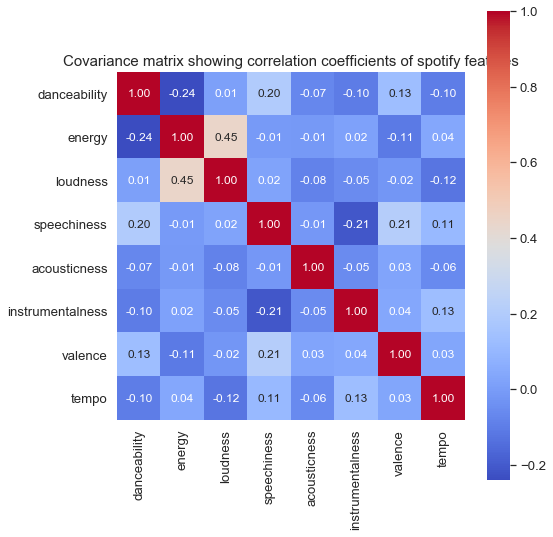

In [15]:
plt.figure(figsize=(8,8))
sns.set(font_scale=1.2)
cols = list(feat_df.iloc[:,1:9].columns)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 cmap='coolwarm',                 
                 yticklabels=cols,
                 xticklabels=cols)
plt.title('Covariance matrix showing correlation coefficients of spotify features', size = 15)
plt.tight_layout()
plt.show()

Most features do not appear to be correlated, except 'loudness' and 'energy' which show some degree of positive correlation.
Since these are custom features engineered and returned by Spotify directly, we can safely use them without expecting anysignificant dependencies.

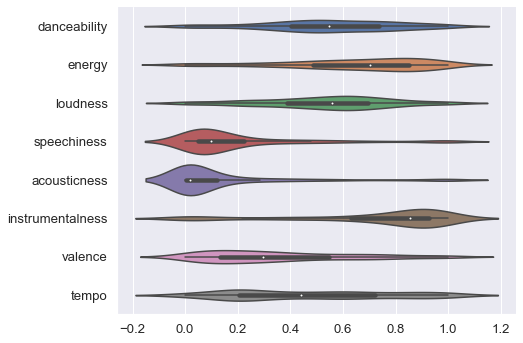

In [16]:
sns.catplot( data=feat_df.iloc[:, 1:9], orient='h', kind='violin', height=5, aspect=1.5)

In [17]:
segstat_df.describe()

,timbre_01_kurtosis,timbre_02_kurtosis,timbre_03_kurtosis,timbre_04_kurtosis,timbre_05_kurtosis,timbre_06_kurtosis,timbre_07_kurtosis,timbre_08_kurtosis,timbre_09_kurtosis,timbre_10_kurtosis,...,timbre_03_std,timbre_04_std,timbre_05_std,timbre_06_std,timbre_07_std,timbre_08_std,timbre_09_std,timbre_10_std,timbre_11_std,timbre_12_std
count,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,...,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000,372.000000
mean,6.569802,2.776866,0.920525,2.151793,0.964597,2.343933,0.508022,1.839376,0.709528,1.669000,...,44.018163,47.540601,24.142483,33.880560,20.257573,21.546118,13.529132,19.101558,20.182826,11.134521
std,12.382819,4.180095,2.149727,5.490526,1.914771,6.016436,1.214806,4.300482,1.286827,3.355139,...,12.282087,17.117537,5.858256,11.576362,4.360447,7.018148,2.993326,6.513628,6.573482,2.239651
min,-1.376668,-1.755253,-1.435712,-1.227449,-1.383618,-1.235547,-1.064180,-1.084835,-0.988754,-1.143028,...,16.066302,18.223398,12.165153,11.485206,10.577313,8.890396,7.716325,9.068600,9.263596,6.954029
25%,0.280161,0.361398,-0.318669,-0.144518,-0.087433,0.097284,-0.241558,0.047505,-0.032455,0.127149,...,35.136080,35.720043,20.257553,26.014844,17.121407,15.853987,11.285084,13.675387,15.507917,9.470518
50%,2.499414,1.684618,0.287661,0.646932,0.543620,0.933432,0.209966,0.806504,0.411285,0.940333,...,43.224115,45.144212,23.162155,31.770704,19.626904,20.450359,13.094180,18.148163,18.911789,10.961349
75%,6.806913,3.560801,1.504296,1.935443,1.354679,2.518219,0.855412,2.040104,1.086551,2.123842,...,51.213688,56.350958,27.274373,40.068413,22.594132,26.293252,15.024891,22.945577,23.937641,12.316894
max,106.386786,34.444353,17.080303,44.321904,18.003024,83.810343,7.321037,62.633732,14.411201,44.292629,...,110.406107,117.039746,47.125492,76.577766,48.043692,46.492296,26.913838,42.286601,50.565395,20.212878


In [18]:
seg_means = segstat_df.filter(regex='mean$',axis=1).head()

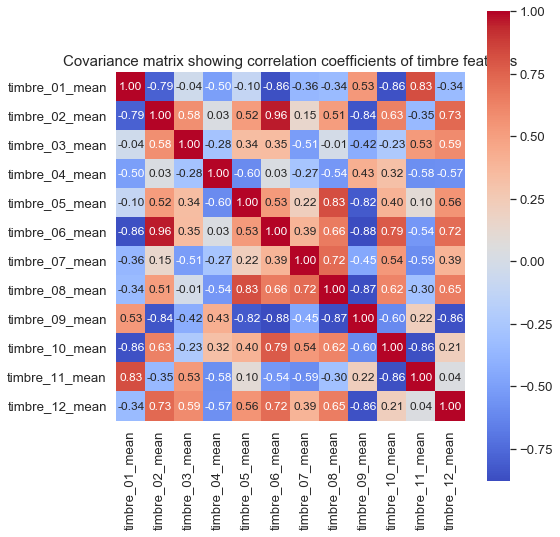

In [19]:
cov_mat = np.corrcoef(seg_means.astype('float32'), rowvar=False)
plt.figure(figsize=(8,8))
sns.set(font_scale=1.2)
cols = list(seg_means.columns)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 cmap='coolwarm',                 
                 yticklabels=cols,
                 xticklabels=cols)
plt.title('Covariance matrix showing correlation coefficients of timbre features', size = 15)
plt.tight_layout()
plt.show()

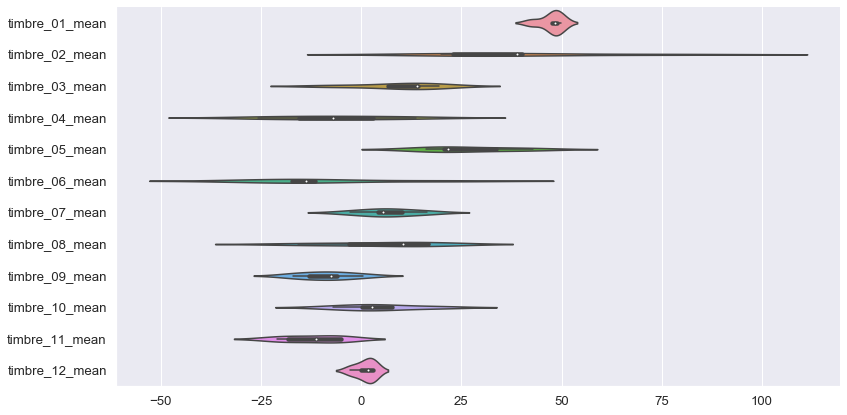

In [20]:
sns.catplot( data=seg_means, orient='h', kind='violin', height=6, aspect=2)